In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math

def psy_analytic(x, lamb = -1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        def A(x, case = 1):
            if case == 1:
                return 1

        def B(x, case = 1):
            if case == 1:
                return 0

        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -1000*(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def PINN(x, NN, case = 1):
    x = x.reshape(-1, 1)
    x = tf.constant(x, dtype = tf.float32)
    x_0 = tf.zeros((1, 1))
    if case == 1:
        one = tf.ones((1, 1))
    elif case == 2:
        one = tf.zeros((1, 1))
    elif case == 3:
        one = -1*tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        PINN_NN = NN(x)
        d_PINN_NN = tape.gradient(PINN_NN, x)

    _loss = d_PINN_NN - f(x, PINN_NN, case)
    IC_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


def train(train_x, n, case):
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

def result_1(Epoch, case = 1):
    '''
        result 1

        w 개수별
        polynomial Graph
        1. Exact
        2. 1st
        3. 2ed
        4. 3rd

        learning_rate = 1e-3
        train_x = 0 ~ 1 사이 20개 균등 배열
        충분히 학습 될 때 까지, Epoch 10000
        Pn(x)로도 충분히 잘 근사 한다.
    '''
    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))


    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, case = case)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, case = case)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, case = case)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, lamb = -1, case = case)
    true_y = psy_analytic(test_x, lamb = -1, case = case)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    pred_y_1 = y(test_x, w_1, case = case)
    pred_y_2 = y(test_x, w_2, case = case)
    pred_y_3 = y(test_x, w_3, case = case)

    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)

    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'Exact')
    ax.plot(test_x, pred_y_1, '--r', label = '1st')
    ax.plot(test_x, pred_y_2, '--b', label = '2ed')
    ax.plot(test_x, pred_y_3, '--g', label = '3rd')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('y', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    ax2.plot(test_x, tf.abs(np.array(pred_y_1).flatten() - true_y), '-r', label = '1st Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_2).flatten() - true_y), '-b', label = '2ed Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_3).flatten() - true_y), '-g', label = '3rd Error')
    ax2.set_xlabel('x', fontsize=15)
    ax2.set_ylabel('Error', fontsize=15)
    ax2.set_title('Error', fontsize=15)
    ax2.tick_params(labelsize=10)
    ax2.legend( fontsize=15)
    ax2.grid()

def result_2(Epoch, case = 1):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        learning_rate = 1e-3
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(1, 10001):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case = case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, train_loss.numpy()))
    
    count = 1
    print('start y + EC and PINN')
    while True:
        print('count :', count)
        NN = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        PINN_NN = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
        for itr in range(1, Epoch+1):
            with tf.GradientTape() as tape:
                train_loss_NN = y_EC_loss(train_x, w, NN, case = case)
                grad_NN = tape.gradient(train_loss_NN, NN.trainable_variables)
                optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))
            
            with tf.GradientTape() as tape:
                train_loss_PINN = PINN(train_x, PINN_NN, case = case)
                grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
                optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

            if itr % 5000 == 0:
                print('iter : {}, yEC_loss : {}'.format(itr, train_loss_NN.numpy()))
                print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))
        
        test_x = np.linspace(0, 1, 100)
        true_y = psy_analytic(test_x, lamb = -1, case = case)
        test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
        test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
        NN_pred_y = tf.add(y(test_x, w, case = case), NN.predict(test_x)*test_x)
        PINN_pred_y = PINN_NN.predict(test_x)

        if tf.reduce_sum(tf.abs(np.array(NN_pred_y).flatten() - true_y)) <= tf.reduce_sum(tf.abs(np.array(PINN_pred_y).flatten() - true_y)): break
        count += 1
        
    # show_graph
    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-r', label = 'y + EC')
    ax.plot(test_x, tf.abs(np.array(PINN_pred_y).flatten() - true_y), '-g', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend( fontsize=15)
    ax.grid()

result 1
---
w 개수별
polynomial Graph
1. Exact
2. 1st
3. 2ed
4. 3rd

train_x = 0 ~ 1 사이 20개 균등 배열

learning_rate = 1e-3

충분히 학습 될 때 까지, Epoch 10000

Pn(x)로도 충분히 잘 근사 한다.

result 2
---
Error Graph

Poly + EC vs PINN

setting
---
train_x : 0 ~ 1 사이 20개 (균등 분배)

learning_rate = 1e-3

layer 개수 : 4개

weight : 32, 64, 64, 32

optimizer function : tanh

Poly weight 개수 : 3개

Poly Epoch : 10,000

Poly + EC, PINN Epoch : 1000, 10000

Example2

Nonlinear

start y
iter : 0, loss_1 : 1.5509302616119385
iter : 0, loss_2 : 1.6869595050811768
iter : 0, loss_3 : 0.26893678307533264
iter : 1000, loss_1 : 0.05840563029050827
iter : 1000, loss_2 : 0.09337608516216278
iter : 1000, loss_3 : 0.033798184245824814
iter : 2000, loss_1 : 0.05541672557592392
iter : 2000, loss_2 : 0.021662095561623573
iter : 2000, loss_3 : 0.013122101314365864
iter : 3000, loss_1 : 0.05541672185063362
iter : 3000, loss_2 : 0.0048439959064126015
iter : 3000, loss_3 : 0.003107792232185602
iter : 4000, loss_1 : 0.05541672557592392
iter : 4000, loss_2 : 0.003474714932963252
iter : 4000, loss_3 : 0.00045473966747522354
iter : 5000, loss_1 : 0.05541672557592392
iter : 5000, loss_2 : 0.0034545015078037977
iter : 5000, loss_3 : 0.0001873410801636055
iter : 6000, loss_1 : 0.05541672557592392
iter : 6000, loss_2 : 0.0034544803202152252
iter : 6000, loss_3 : 0.00018182254279963672
iter : 7000, loss_1 : 0.05541672557592392
iter : 7000, loss_2 : 0.0034544803202152252
iter : 7000, los

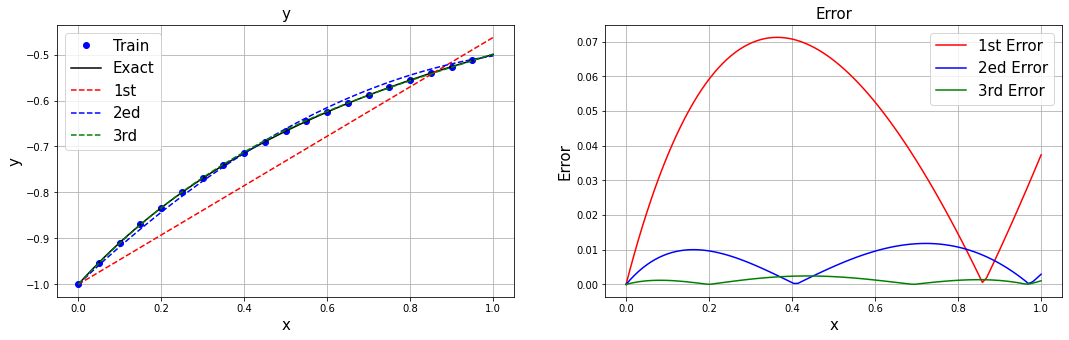

In [20]:
result_1(Epoch = 10000, case = 3)

start y
iter : 5000, y_loss : 0.0003411933430470526
iter : 10000, y_loss : 0.00018181464110966772
start y + EC and PINN
count : 1
4/4 [==============================] - 0s 977us/step
count : 2
4/4 [==============================] - 0s 977us/step
count : 3
4/4 [==============================] - 0s 817us/step
count : 4
4/4 [==============================] - 0s 657us/step
count : 5
4/4 [==============================] - 0s 557us/step
count : 6
4/4 [==============================] - 0s 977us/step
count : 7
4/4 [==============================] - 0s 886us/step
count : 8
4/4 [==============================] - 0s 977us/step
count : 9
4/4 [==============================] - 0s 881us/step
count : 10
4/4 [==============================] - 0s 820us/step
count : 11
4/4 [==============================] - 0s 793us/step
count : 12
4/4 [==============================] - 0s 651us/step
count : 13
4/4 [==============================] - 0s 907us/step
count : 14
4/4 [==============================] - 0s 703u

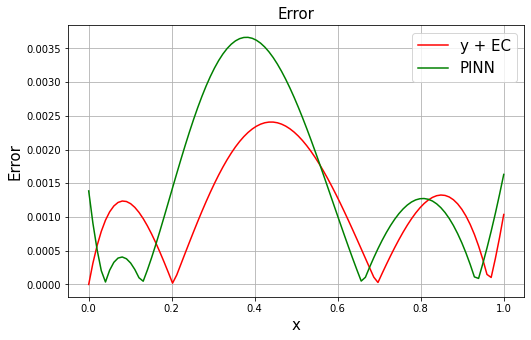

In [52]:
result_2(Epoch = 1000, case = 3)

start y
iter : 5000, y_loss : 0.0001939412613864988
iter : 10000, y_loss : 0.00018181465566158295
start y + EC and PINN
count : 1
iter : 5000, yEC_loss : 9.579195648257155e-06
iter : 5000, PINN_loss : 2.6337352210248355e-06
iter : 10000, yEC_loss : 2.2121488996162952e-07
iter : 10000, PINN_loss : 5.727525831389357e-07
4/4 [==============================] - 0s 2ms/step


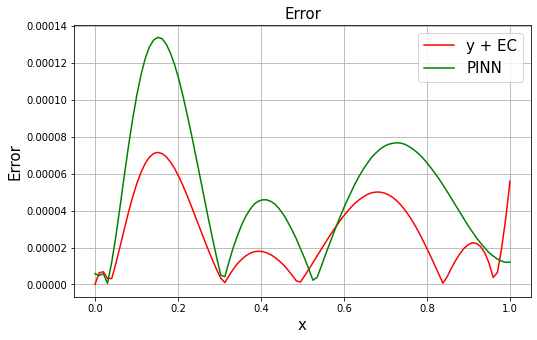

In [45]:
result_2(Epoch = 10000, case = 3)

Example3

prothero-robinson

lambda -1, -1000

start y
iter : 0, loss_1 : 4.166861534118652
iter : 0, loss_2 : 0.17787957191467285
iter : 0, loss_3 : 5.729262351989746
iter : 1000, loss_1 : 0.24908415973186493
iter : 1000, loss_2 : 0.0012316920328885317
iter : 1000, loss_3 : 0.04241485521197319
iter : 2000, loss_1 : 0.021685604006052017
iter : 2000, loss_2 : 0.0010709533235058188
iter : 2000, loss_3 : 0.01905873790383339
iter : 3000, loss_1 : 0.018920283764600754
iter : 3000, loss_2 : 0.0010709529742598534
iter : 3000, loss_3 : 0.010642685927450657
iter : 4000, loss_1 : 0.018918519839644432
iter : 4000, loss_2 : 0.001070951810106635
iter : 4000, loss_3 : 0.00856592133641243
iter : 5000, loss_1 : 0.01891852356493473
iter : 5000, loss_2 : 0.0010709530906751752
iter : 5000, loss_3 : 0.007021126337349415
iter : 6000, loss_1 : 0.01891852170228958
iter : 6000, loss_2 : 0.001070952508598566
iter : 6000, loss_3 : 0.0050893500447273254
iter : 7000, loss_1 : 0.01891852356493473
iter : 7000, loss_2 : 0.0010709528578445315
iter : 7000, loss_3 

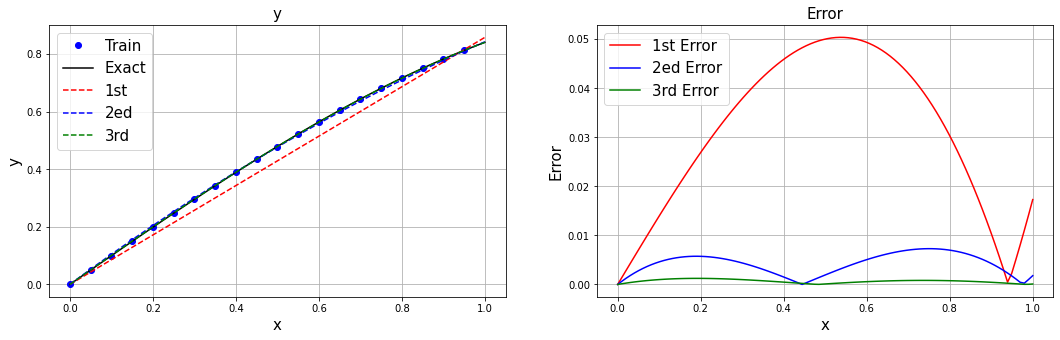

In [40]:
result_1(Epoch = 10000, case = 2)

lambda -1

start y
iter : 5000, y_loss : 0.016965221613645554
iter : 10000, y_loss : 0.001181002357043326
start y + EC and PINN
count : 1
4/4 [==============================] - 0s 977us/step
count : 2
4/4 [==============================] - 0s 2ms/step
count : 3
4/4 [==============================] - 0s 2ms/step


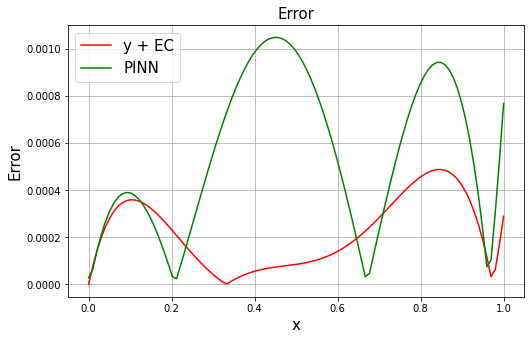

In [41]:
result_2(Epoch = 1000, case = 2)

start y
iter : 5000, y_loss : 2.6949098810291616e-06
iter : 10000, y_loss : 1.9971694200648926e-06
start y + EC and PINN
count : 1
iter : 5000, yEC_loss : 1.9188676105841296e-06
iter : 5000, PINN_loss : 2.69293668679893e-05
iter : 10000, yEC_loss : 3.653756763810634e-08
iter : 10000, PINN_loss : 1.4738494428456761e-05
4/4 [==============================] - 0s 1ms/step


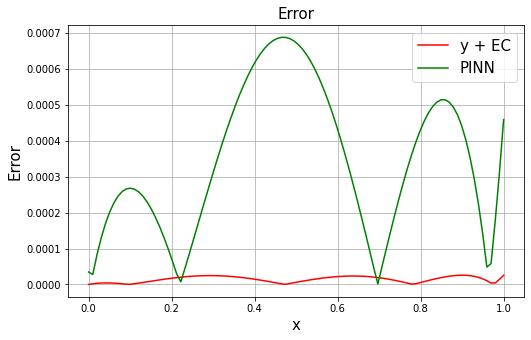

In [43]:
result_2(Epoch = 10000, case = 2)

lambda -1000

start y
iter : 5000, y_loss : 38.94045639038086
iter : 10000, y_loss : 2.4647183418273926
start y + EC and PINN
count : 1
4/4 [==============================] - 0s 1ms/step
count : 2
4/4 [==============================] - 0s 1ms/step
count : 3
4/4 [==============================] - 0s 652us/step
count : 4
4/4 [==============================] - 0s 651us/step
count : 5
4/4 [==============================] - 0s 820us/step
count : 6
4/4 [==============================] - 0s 977us/step
count : 7
4/4 [==============================] - 0s 978us/step
count : 8
4/4 [==============================] - 0s 977us/step
count : 9
4/4 [==============================] - 0s 977us/step
count : 10
4/4 [==============================] - 0s 984us/step
count : 11
4/4 [==============================] - 0s 1ms/step
count : 12
4/4 [==============================] - 0s 743us/step
count : 13
4/4 [==============================] - 0s 978us/step
count : 14
4/4 [==============================] - 0s 985us/step
count :

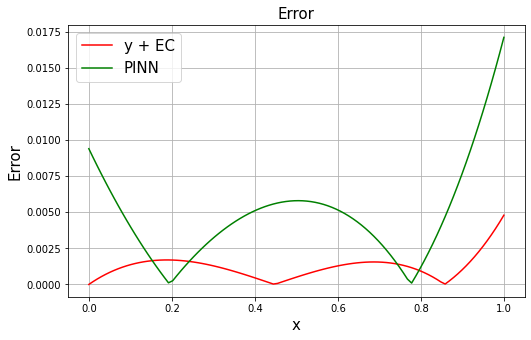

In [50]:
result_2(Epoch = 1000, case = 2)

start y
iter : 5000, y_loss : 4949.56494140625
iter : 10000, y_loss : 8.767938613891602
start y + EC and PINN
count : 1
iter : 5000, yEC_loss : 0.009256819263100624
iter : 5000, PINN_loss : 0.154084712266922
iter : 10000, yEC_loss : 0.02253665402531624
iter : 10000, PINN_loss : 0.2636822760105133
4/4 [==============================] - 0s 977us/step


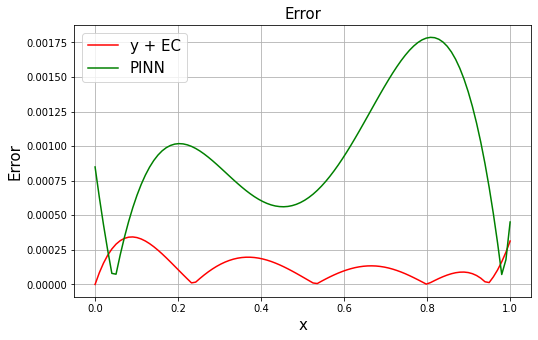

In [49]:
result_2(Epoch = 10000, case = 2)